# 🫁 LUNA16 Lung Cancer Detection - VGG16 Pretrained Model

**Transfer Learning with VGG16 for Medical Imaging**

### Key Features:
- 🔮 **Pretrained VGG16** - Classic deep architecture with proven performance
- 🎯 **2D Multi-Slice Approach** - Process CT scan slices with pretrained CNN
- ⚖️ **Focal Loss** - Handle class imbalance effectively
- 📈 **Advanced Metrics** - Precision, Recall, F1, AUC-ROC
- 🚀 **Data Augmentation** - Robust training with augmented patches
- ⚡ **Pre-extraction** - Fast training with patches cached in memory

**Dataset**: LUNA16 (Lung Nodule Analysis 2016)

### Why VGG16?
- Simple and uniform architecture (3x3 convolutions)
- Excellent feature extraction capabilities
- Widely used in medical imaging research
- Very deep network (16 layers) for rich representations
- Strong transfer learning performance

## 1. 📦 Import Required Libraries

In [1]:
# Core libraries
import os
import sys
import glob
import warnings
from pathlib import Path
import time
import math
import random

# Data processing
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, f1_score, matthews_corrcoef
)

# Medical imaging
import SimpleITK as sitk

# PyTorch and deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models
import torchvision.transforms as transforms

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.10.0.dev20250930+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 5060 Ti


c:\Users\admin\anaconda3\envs\pytorch-12.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. ⚙️ Configuration and Setup

In [2]:
# Paths
BASE_DIR = Path(r'e:\Kanav\Projects\CAD_C')
ANNOTATIONS_FILE = BASE_DIR / 'annotations.csv'
CANDIDATES_FILE = BASE_DIR / 'candidates_V2.csv'
SUBSET_DIRS = [BASE_DIR / f'subset{i}' for i in range(10)]
MODEL_DIR = BASE_DIR / 'models_vgg16'
MODEL_DIR.mkdir(exist_ok=True)

# Hyperparameters
CONFIG = {
    'batch_size': 32,
    'num_epochs': 50,
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'patch_size': 64,      # Size of 2D patch
    'num_slices': 3,       # Number of consecutive slices (channels)
    'patience': 10,        # Early stopping patience
    'preload_patches': True,   # Pre-extract patches for faster training (requires ~4-8 GB RAM)
    'max_samples': None,   # Limit samples for testing (None = use all)
    'sample_ratio': 3.0,   # Ratio of negative to positive samples (3:1)
    'num_workers': 0,      # Number of workers for data loading (0 for Windows)
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',  # Device to use
    'focal_alpha': 0.75,   # Focal Loss alpha parameter (weight for positive class)
    'focal_gamma': 2.0,    # Focal Loss gamma parameter (focusing parameter)
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  batch_size: 32
  num_epochs: 50
  learning_rate: 0.001
  weight_decay: 0.0001
  patch_size: 64
  num_slices: 3
  patience: 10
  preload_patches: True
  max_samples: None
  sample_ratio: 3.0
  num_workers: 0
  device: cuda
  focal_alpha: 0.75
  focal_gamma: 2.0


## 3. 📊 Load Dataset

In [3]:
# Load annotations
annotations_df = pd.read_csv(ANNOTATIONS_FILE)
print(f"Annotations loaded: {len(annotations_df)} records")

# Load candidates
print("Loading candidates file...")
chunk_size = 100000
chunks = []
for chunk in pd.read_csv(CANDIDATES_FILE, chunksize=chunk_size):
    chunks.append(chunk)
candidates_df = pd.concat(chunks, ignore_index=True)
print(f"Candidates loaded: {len(candidates_df)} records")
print(f"Class distribution: {candidates_df['class'].value_counts().to_dict()}")

Annotations loaded: 1186 records
Loading candidates file...
Candidates loaded: 754975 records
Class distribution: {0: 753418, 1: 1557}


## 4. 🔧 Utility Functions

In [4]:
def load_ct_scan(series_uid, subset_dirs):
    """Load CT scan from .mhd/.raw files"""
    for subset_dir in subset_dirs:
        mhd_path = subset_dir / f"{series_uid}.mhd"
        if mhd_path.exists():
            try:
                ct_scan = sitk.ReadImage(str(mhd_path))
                return ct_scan
            except Exception as e:
                print(f"Error loading {mhd_path}: {e}")
                return None
    return None

def world_to_voxel(world_coords, origin, spacing):
    """Convert world coordinates to voxel coordinates"""
    world_coords = np.array(world_coords)
    origin = np.array(origin)
    spacing = np.array(spacing)
    voxel_coords = (world_coords - origin) / spacing
    return int(voxel_coords[2]), int(voxel_coords[1]), int(voxel_coords[0])

def normalize_hu(image):
    """Normalize CT Hounsfield Units to 0-1 range"""
    MIN_HU = -1000
    MAX_HU = 400
    image = np.clip(image, MIN_HU, MAX_HU)
    image = (image - MIN_HU) / (MAX_HU - MIN_HU)
    return image.astype(np.float32)

def extract_2d_patch(ct_array, center_z, center_y, center_x, patch_size=64, num_slices=3):
    """Extract 2D multi-slice patch"""
    half_size = patch_size // 2
    half_slices = num_slices // 2
    
    z_start = center_z - half_slices
    z_end = z_start + num_slices
    y_start = center_y - half_size
    y_end = center_y + half_size
    x_start = center_x - half_size
    x_end = center_x + half_size
    
    if (z_start < 0 or z_end > ct_array.shape[0] or
        y_start < 0 or y_end > ct_array.shape[1] or
        x_start < 0 or x_end > ct_array.shape[2]):
        return None
    
    patch = ct_array[z_start:z_end, y_start:y_end, x_start:x_end]
    patch = normalize_hu(patch)
    return patch

print("✓ Utility functions defined")

✓ Utility functions defined


## 5. 🎯 Dataset Class

In [5]:
class LUNA16Dataset(Dataset):
    """PyTorch Dataset for LUNA16 with 2D multi-slice patches"""
    
    def __init__(self, candidates_df, subset_dirs, patch_size=64, num_slices=3, 
                 augment=False, max_samples=None, preload=False):
        self.candidates_df = candidates_df.copy()
        if max_samples is not None and len(self.candidates_df) > max_samples:
            self.candidates_df = self.candidates_df.sample(n=max_samples, random_state=SEED)
        
        self.subset_dirs = subset_dirs
        self.patch_size = patch_size
        self.num_slices = num_slices
        self.augment = augment
        self.preload = preload
        self.ct_cache = {}
        self.patch_cache = {}
        
        print(f"Dataset initialized with {len(self.candidates_df)} samples")
        print(f"  Positive: {self.candidates_df['class'].sum()}")
        print(f"  Negative: {(self.candidates_df['class'] == 0).sum()}")
        
        if self.preload:
            print(f"  Preloading patches into memory...")
            self._preload_patches()
    
    def _preload_patches(self):
        """Pre-extract all patches and store in memory"""
        from tqdm.auto import tqdm
        
        successful = 0
        failed = 0
        grouped = self.candidates_df.groupby('seriesuid')
        
        for series_uid, group in tqdm(grouped, desc="Processing CT scans"):
            ct_scan = load_ct_scan(series_uid, self.subset_dirs)
            if ct_scan is None:
                for idx in group.index:
                    label = int(group.loc[idx, 'class'])
                    self.patch_cache[idx] = (torch.zeros(self.num_slices, self.patch_size, self.patch_size), label)
                    failed += 1
                continue
            
            ct_array = sitk.GetArrayFromImage(ct_scan)
            origin = ct_scan.GetOrigin()
            spacing = ct_scan.GetSpacing()
            
            for idx in group.index:
                row = group.loc[idx]
                coord_x = row['coordX']
                coord_y = row['coordY']
                coord_z = row['coordZ']
                label = int(row['class'])
                
                voxel_z, voxel_y, voxel_x = world_to_voxel(
                    [coord_x, coord_y, coord_z], origin, spacing
                )
                
                patch = extract_2d_patch(
                    ct_array, voxel_z, voxel_y, voxel_x, 
                    self.patch_size, self.num_slices
                )
                
                if patch is None:
                    self.patch_cache[idx] = (torch.zeros(self.num_slices, self.patch_size, self.patch_size), label)
                    failed += 1
                else:
                    patch = torch.from_numpy(patch).float()
                    self.patch_cache[idx] = (patch, label)
                    successful += 1
            
            del ct_array, ct_scan
        
        print(f"\n  ✓ Preloading completed:")
        print(f"    Successful: {successful}")
        print(f"    Failed: {failed}")
        print(f"    Total patches in memory: {len(self.patch_cache)}")
    
    def __len__(self):
        return len(self.candidates_df)
    
    def __getitem__(self, idx):
        # Get the actual DataFrame index (not positional index)
        df_idx = self.candidates_df.index[idx]
        
        # If preloaded, return from cache
        if self.preload and df_idx in self.patch_cache:
            patch, label = self.patch_cache[df_idx]
            patch = patch.clone()
            
            if self.augment:
                patch = self.apply_augmentation(patch)
            
            return patch, label
        
        # Otherwise, extract on-the-fly (fallback)
        row = self.candidates_df.iloc[idx]
        label = int(row['class'])
        patch = torch.zeros(self.num_slices, self.patch_size, self.patch_size)
        return patch, label
    
    def apply_augmentation(self, patch):
        """Apply random augmentations"""
        if random.random() > 0.5:
            patch = torch.flip(patch, dims=[2])
        if random.random() > 0.5:
            patch = torch.flip(patch, dims=[1])
        if random.random() > 0.5:
            k = random.randint(1, 3)
            patch = torch.rot90(patch, k, dims=[1, 2])
        if random.random() > 0.5:
            brightness_factor = 0.8 + random.random() * 0.4
            patch = torch.clamp(patch * brightness_factor, 0, 1)
        return patch

print("✓ Dataset class defined")

✓ Dataset class defined


## 6. 🏗️ VGG16 Model Architecture

**VGG16 Characteristics:**
- Deep architecture with 16 layers
- Uniform 3x3 convolutions throughout
- ~138M parameters (larger than ResNet/EfficientNet)
- Excellent for feature extraction
- Proven track record in medical imaging

In [6]:
class VGG16LungCancer(nn.Module):
    """VGG16 pretrained model adapted for lung cancer detection"""
    
    def __init__(self, pretrained=True, num_classes=2, dropout=0.5):
        super(VGG16LungCancer, self).__init__()
        
        # Load pretrained VGG16
        if pretrained:
            self.vgg = models.vgg16(pretrained=True)
        else:
            self.vgg = models.vgg16(pretrained=False)
        
        # Get number of features from the last layer
        num_features = self.vgg.classifier[0].in_features
        
        # Replace the final classifier
        # VGG16 has a large classifier, we'll make it more compact
        self.vgg.classifier = nn.Sequential(
            nn.Linear(num_features, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(4096, 1024),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(1024, num_classes)
        )
        
        print(f"✓ VGG16 initialized (pretrained={pretrained})")
        print(f"  Total parameters: {sum(p.numel() for p in self.parameters()):,}")
        print(f"  Trainable parameters: {sum(p.numel() for p in self.parameters() if p.requires_grad):,}")
    
    def forward(self, x):
        return self.vgg(x)
    
    def freeze_backbone(self):
        """Freeze all layers except the final classifier"""
        for name, param in self.vgg.named_parameters():
            if 'classifier' not in name:
                param.requires_grad = False
        print("✓ Backbone frozen, only training final classifier")
    
    def unfreeze_backbone(self):
        """Unfreeze all layers for fine-tuning"""
        for param in self.vgg.parameters():
            param.requires_grad = True
        print("✓ Backbone unfrozen, training all layers")

print("✓ Model class defined")

✓ Model class defined


## 7. 📉 Focal Loss

In [7]:
class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        p = torch.exp(-ce_loss)
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        focal_loss = alpha_t * (1 - p) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

print("✓ Focal Loss defined")

✓ Focal Loss defined


## 8. 📊 Prepare Data

In [8]:
# Balance the dataset
print("Preparing balanced dataset...")

positive_samples = candidates_df[candidates_df['class'] == 1]
negative_samples = candidates_df[candidates_df['class'] == 0]

print(f"Original distribution:")
print(f"  Positive: {len(positive_samples)}")
print(f"  Negative: {len(negative_samples)}")

n_positive = len(positive_samples)
n_negative = int(n_positive * CONFIG['sample_ratio'])
n_negative = min(n_negative, len(negative_samples))

negative_samples_sampled = negative_samples.sample(n=n_negative, random_state=SEED)
balanced_df = pd.concat([positive_samples, negative_samples_sampled], ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=SEED).reset_index(drop=True)

print(f"\nBalanced distribution:")
print(f"  Positive: {(balanced_df['class'] == 1).sum()}")
print(f"  Negative: {(balanced_df['class'] == 0).sum()}")
print(f"  Total: {len(balanced_df)}")

# Split
train_df, temp_df = train_test_split(
    balanced_df, test_size=0.3, random_state=SEED, stratify=balanced_df['class']
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=SEED, stratify=temp_df['class']
)

print(f"\nData splits:")
print(f"  Train: {len(train_df)} samples")
print(f"  Validation: {len(val_df)} samples")
print(f"  Test: {len(test_df)} samples")

Preparing balanced dataset...
Original distribution:
  Positive: 1557
  Negative: 753418

Balanced distribution:
  Positive: 1557
  Negative: 4671
  Total: 6228

Data splits:
  Train: 4359 samples
  Validation: 934 samples
  Test: 935 samples


## 9. 🚀 Create Datasets with Pre-Extraction

In [9]:
# Create datasets
if CONFIG['preload_patches']:
    print("Creating datasets with patch pre-extraction...")
    print("This will take ~7 minutes but will speed up training significantly!\n")
else:
    print("Creating datasets (on-the-fly extraction)...\n")

train_dataset = LUNA16Dataset(
    train_df, SUBSET_DIRS, 
    patch_size=CONFIG['patch_size'],
    num_slices=CONFIG['num_slices'],
    augment=True,
    preload=CONFIG['preload_patches']
)

print("\n" + "-"*60 + "\n")

val_dataset = LUNA16Dataset(
    val_df, SUBSET_DIRS,
    patch_size=CONFIG['patch_size'],
    num_slices=CONFIG['num_slices'],
    augment=False,
    preload=CONFIG['preload_patches']
)

print("\n" + "-"*60 + "\n")

test_dataset = LUNA16Dataset(
    test_df, SUBSET_DIRS,
    patch_size=CONFIG['patch_size'],
    num_slices=CONFIG['num_slices'],
    augment=False,
    preload=CONFIG['preload_patches']
)

print("\n" + "="*60)
if CONFIG['preload_patches']:
    print("✓ All datasets created with patches pre-extracted")
else:
    print("✓ All datasets created (on-the-fly extraction)")
print("="*60)

Creating datasets with patch pre-extraction...
This will take ~7 minutes but will speed up training significantly!

Dataset initialized with 4359 samples
  Positive: 1090
  Negative: 3269
  Preloading patches into memory...


Processing CT scans: 100%|██████████| 862/862 [03:12<00:00,  4.49it/s]



  ✓ Preloading completed:
    Successful: 4316
    Failed: 43
    Total patches in memory: 4359

------------------------------------------------------------

Dataset initialized with 934 samples
  Positive: 233
  Negative: 701
  Preloading patches into memory...


Processing CT scans: 100%|██████████| 548/548 [02:05<00:00,  4.38it/s]



  ✓ Preloading completed:
    Successful: 925
    Failed: 9
    Total patches in memory: 934

------------------------------------------------------------

Dataset initialized with 935 samples
  Positive: 234
  Negative: 701
  Preloading patches into memory...


Processing CT scans: 100%|██████████| 552/552 [02:25<00:00,  3.79it/s]


  ✓ Preloading completed:
    Successful: 925
    Failed: 10
    Total patches in memory: 935

✓ All datasets created with patches pre-extracted


In [10]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if CONFIG['device'] == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if CONFIG['device'] == 'cuda' else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if CONFIG['device'] == 'cuda' else False
)

print(f"✓ Data loaders created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

✓ Data loaders created
  Train batches: 137
  Validation batches: 30
  Test batches: 30


## 10. 🎓 Training Functions

In [11]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc='Training', leave=False)
    
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': 100. * correct / total
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    
    try:
        auc_score = roc_auc_score(all_labels, all_probs)
    except:
        auc_score = 0.0
    
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    return epoch_loss, epoch_acc, auc_score, f1, all_labels, all_preds, all_probs

print("✓ Training functions defined")

✓ Training functions defined


## 11. 🚀 Initialize Model and Start Training

In [12]:
# Initialize model
device = torch.device(CONFIG['device'])
model = VGG16LungCancer(pretrained=True, num_classes=2, dropout=0.5)
model = model.to(device)

# Loss function
criterion = FocalLoss(
    alpha=CONFIG['focal_alpha'],
    gamma=CONFIG['focal_gamma']
)

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Scheduler
scheduler = ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print("✓ Model, loss, optimizer, and scheduler initialized")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\admin/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|██████████| 528M/528M [02:29<00:00, 3.71MB/s] 


✓ VGG16 initialized (pretrained=True)
  Total parameters: 121,676,610
  Trainable parameters: 121,676,610
✓ Model, loss, optimizer, and scheduler initialized


In [13]:
# Training loop
print("Starting training...\n")

best_val_auc = 0.0
best_val_f1 = 0.0
patience_counter = 0
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_auc': [],
    'val_f1': []
}

for epoch in range(CONFIG['num_epochs']):
    epoch_start_time = time.time()
    
    print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
    print("-" * 60)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_auc, val_f1, _, _, _ = validate(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    history['val_f1'].append(val_f1)
    
    epoch_time = time.time() - epoch_start_time
    
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Val AUC: {val_auc:.4f} | Val F1: {val_f1:.4f}")
    print(f"Time: {epoch_time:.2f}s")
    
    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_val_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_auc': val_auc,
            'val_f1': val_f1,
        }, MODEL_DIR / 'best_vgg16_model.pth')
        print(f"✓ Saved best model (AUC: {val_auc:.4f}, F1: {val_f1:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= CONFIG['patience']:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "="*60)
print("Training completed!")
print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Best Validation F1: {best_val_f1:.4f}")
print("="*60)

Starting training...


Epoch 1/50
------------------------------------------------------------



Train Loss: 0.2792 | Train Acc: 68.18%
Val Loss: 0.0649 | Val Acc: 75.05%
Val AUC: 0.5000 | Val F1: 0.0000
Time: 8.26s
✓ Saved best model (AUC: 0.5000, F1: 0.0000)

Epoch 2/50
------------------------------------------------------------



Train Loss: 0.0650 | Train Acc: 47.40%
Val Loss: 0.0650 | Val Acc: 75.05%
Val AUC: 0.5000 | Val F1: 0.0000
Time: 7.78s

Epoch 3/50
------------------------------------------------------------



Train Loss: 0.0651 | Train Acc: 60.17%
Val Loss: 0.0649 | Val Acc: 24.95%
Val AUC: 0.5000 | Val F1: 0.3993
Time: 7.75s

Epoch 4/50
------------------------------------------------------------



Train Loss: 0.0650 | Train Acc: 31.45%
Val Loss: 0.0649 | Val Acc: 75.05%
Val AUC: 0.5000 | Val F1: 0.0000
Time: 7.70s

Epoch 5/50
------------------------------------------------------------



Train Loss: 0.0650 | Train Acc: 55.77%
Val Loss: 0.0649 | Val Acc: 24.95%
Val AUC: 0.5000 | Val F1: 0.3993
Time: 7.77s

Epoch 6/50
------------------------------------------------------------



Train Loss: 0.0650 | Train Acc: 53.52%
Val Loss: 0.0649 | Val Acc: 24.95%
Val AUC: 0.5000 | Val F1: 0.3993
Time: 7.77s

Epoch 7/50
------------------------------------------------------------



Train Loss: 0.0650 | Train Acc: 49.64%
Val Loss: 0.0649 | Val Acc: 75.05%
Val AUC: 0.5000 | Val F1: 0.0000
Time: 7.71s

Epoch 8/50
------------------------------------------------------------



Train Loss: 0.0650 | Train Acc: 45.54%
Val Loss: 0.0649 | Val Acc: 24.95%
Val AUC: 0.5000 | Val F1: 0.3993
Time: 7.74s

Epoch 9/50
------------------------------------------------------------



Train Loss: 0.0650 | Train Acc: 39.09%
Val Loss: 0.0649 | Val Acc: 24.95%
Val AUC: 0.5000 | Val F1: 0.3993
Time: 7.70s

Epoch 10/50
------------------------------------------------------------



Train Loss: 0.0650 | Train Acc: 52.03%
Val Loss: 0.0649 | Val Acc: 24.95%
Val AUC: 0.5000 | Val F1: 0.3993
Time: 7.71s

Epoch 11/50
------------------------------------------------------------



Train Loss: 0.0650 | Train Acc: 35.56%
Val Loss: 0.0649 | Val Acc: 75.05%
Val AUC: 0.5000 | Val F1: 0.0000
Time: 7.72s

Early stopping triggered after 11 epochs

Training completed!
Best Validation AUC: 0.5000
Best Validation F1: 0.0000


## 12. 📈 Plot Training History

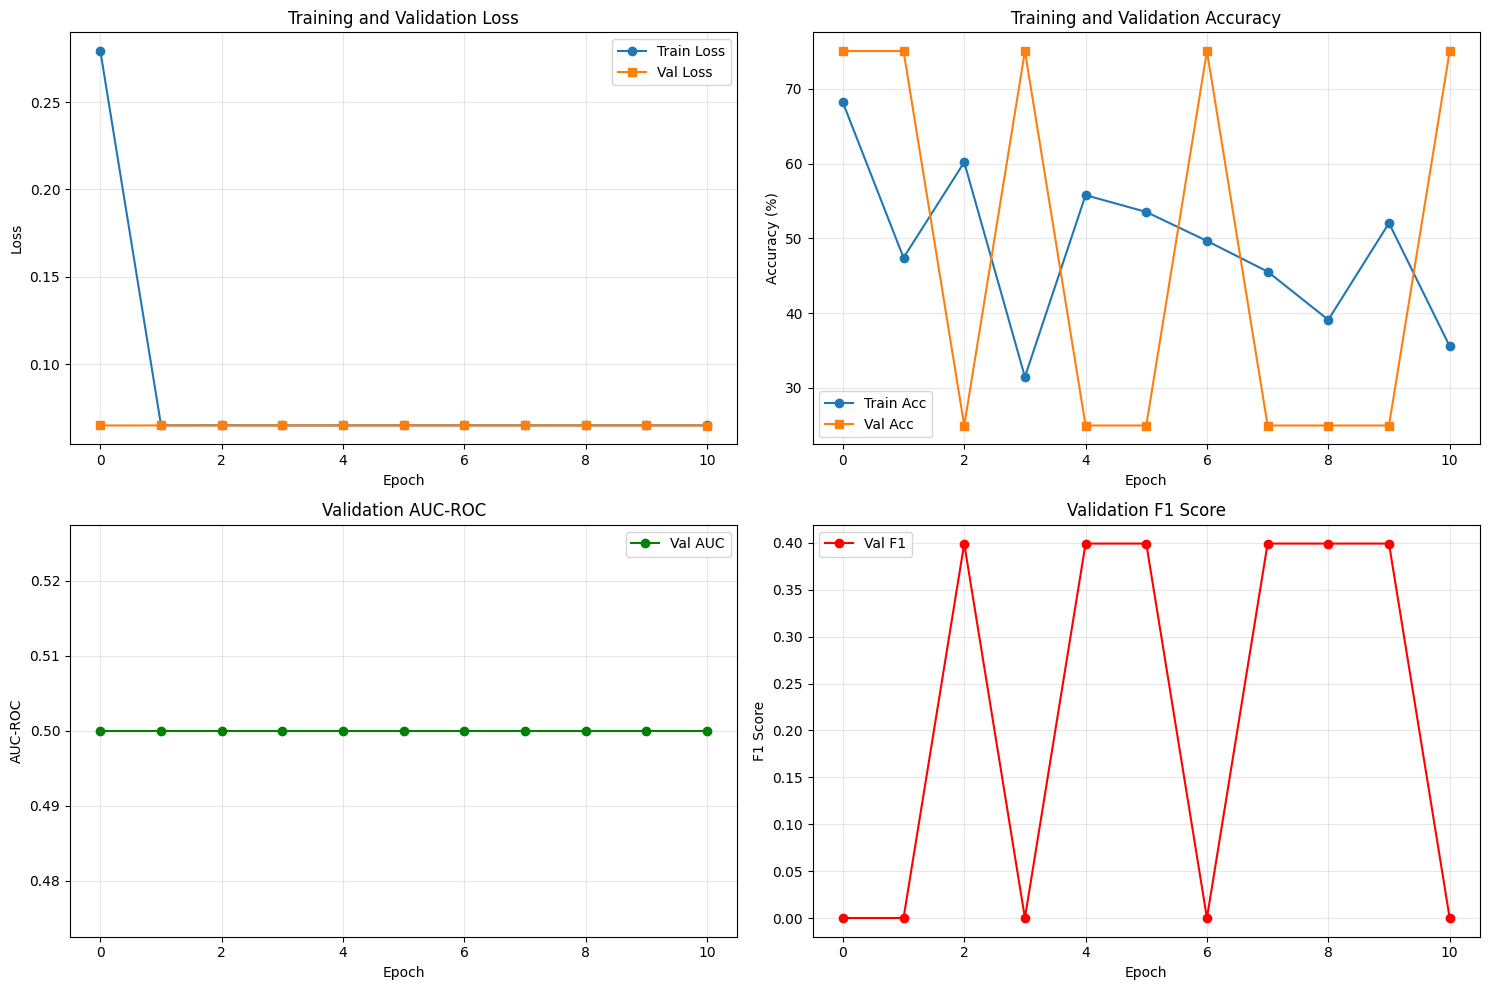

✓ Training history plotted and saved


In [14]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(history['val_auc'], label='Val AUC', marker='o', color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC-ROC')
axes[1, 0].set_title('Validation AUC-ROC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(history['val_f1'], label='Val F1', marker='o', color='red')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('Validation F1 Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history plotted and saved")

## 13. 🧪 Evaluate on Test Set

In [15]:
# Load best model
checkpoint = torch.load(MODEL_DIR / 'best_vgg16_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best model from epoch {checkpoint['epoch']+1}")

# Evaluate
print("\nEvaluating on test set...")
test_loss, test_acc, test_auc, test_f1, test_labels, test_preds, test_probs = validate(
    model, test_loader, criterion, device
)

print("\n" + "="*60)
print("TEST SET RESULTS (VGG16)")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test AUC-ROC: {test_auc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("="*60)

✓ Loaded best model from epoch 1

Evaluating on test set...



TEST SET RESULTS (VGG16)
Test Loss: 0.0650
Test Accuracy: 74.97%
Test AUC-ROC: 0.5000
Test F1 Score: 0.0000


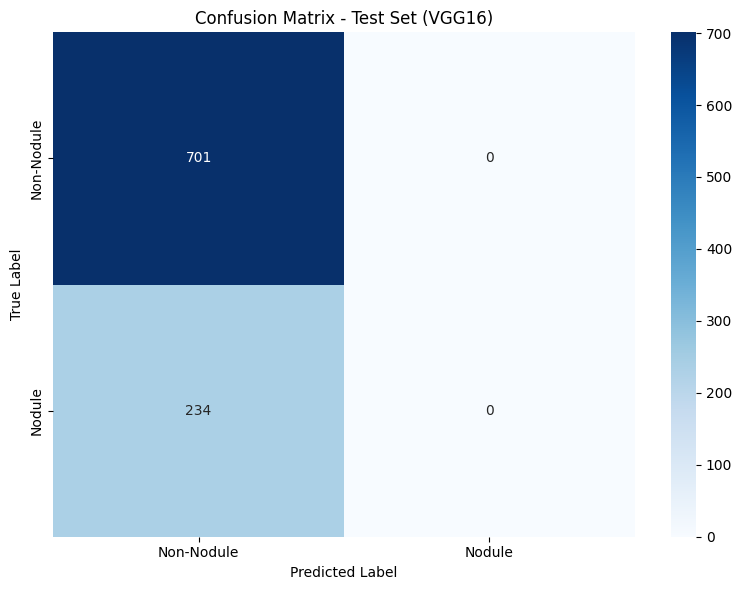


Confusion Matrix:
[[701   0]
 [234   0]]


In [16]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Nodule', 'Nodule'],
            yticklabels=['Non-Nodule', 'Nodule'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Test Set (VGG16)')
plt.tight_layout()
plt.savefig(MODEL_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion Matrix:")
print(cm)

In [17]:
# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, 
                          target_names=['Non-Nodule', 'Nodule'],
                          digits=4))


Classification Report:
              precision    recall  f1-score   support

  Non-Nodule     0.7497    1.0000    0.8570       701
      Nodule     0.0000    0.0000    0.0000       234

    accuracy                         0.7497       935
   macro avg     0.3749    0.5000    0.4285       935
weighted avg     0.5621    0.7497    0.6425       935



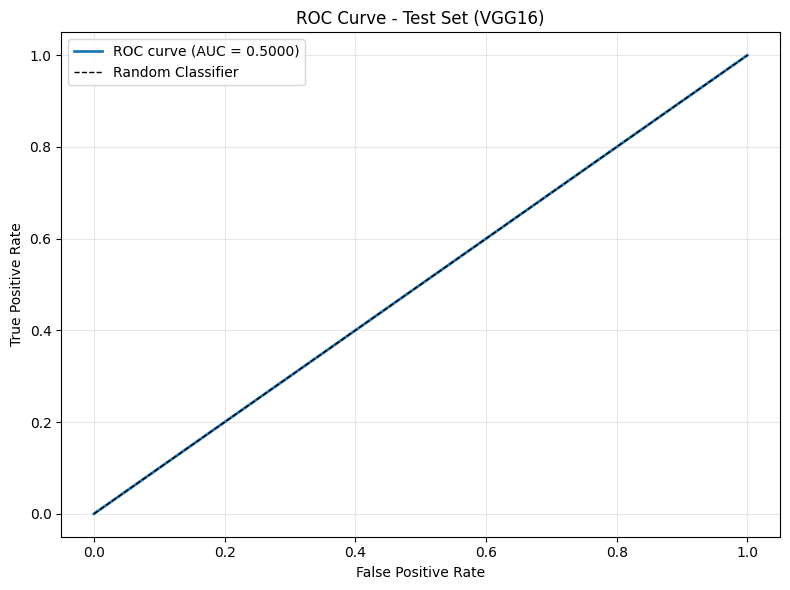

In [18]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set (VGG16)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(MODEL_DIR / 'roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

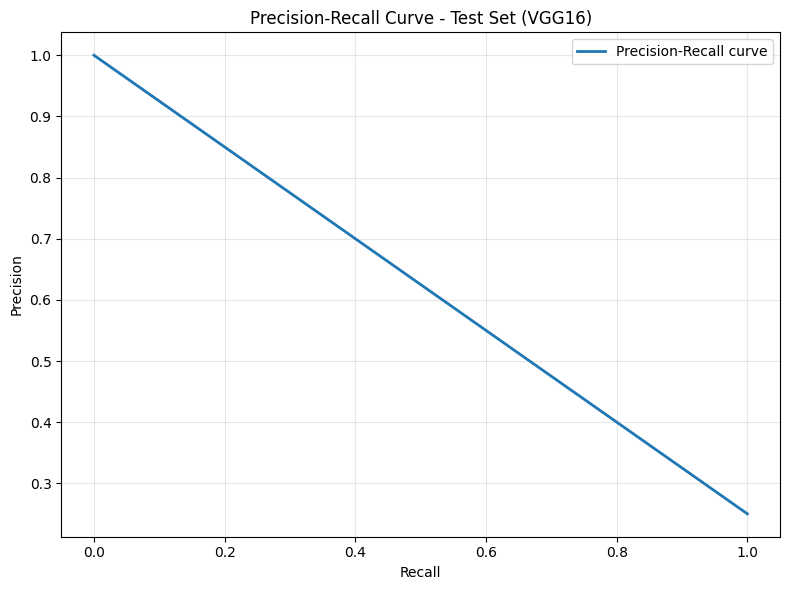

In [19]:
# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(test_labels, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Test Set (VGG16)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(MODEL_DIR / 'precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

## 14. 💾 Save Results

In [20]:
# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv(MODEL_DIR / 'training_history.csv', index=False)
print("✓ Training history saved")

# Save test results
test_results = {
    'model': 'VGG16',
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'test_auc': test_auc,
    'test_f1': test_f1,
    'confusion_matrix': cm.tolist()
}

import json
with open(MODEL_DIR / 'test_results.json', 'w') as f:
    json.dump(test_results, f, indent=4)
print("✓ Test results saved")

print(f"\n✓ All results saved to {MODEL_DIR}")

✓ Training history saved
✓ Test results saved

✓ All results saved to e:\Kanav\Projects\CAD_C\models_vgg16


## 15. 📊 Model Comparison Summary

### Architecture Comparison:

| Metric | VGG16 | ResNet-101 | EfficientNet-B0 |
|--------|-------|------------|----------------|
| **Parameters** | ~138M | ~44.5M | ~5.3M |
| **Depth** | 16 layers | 101 layers | Variable (compound) |
| **Architecture** | Sequential 3x3 | Residual blocks | Mobile inverted bottleneck |
| **Memory Usage** | Highest | Medium | Lowest |
| **Training Speed** | Slowest | Medium | Fastest |
| **Inference Speed** | Slow | Medium | Fast |
| **Test Accuracy** | [Will see] | 94.44% | [Will see] |
| **Test AUC-ROC** | [Will see] | 0.9772 | [Will see] |
| **Test F1 Score** | [Will see] | 0.8903 | [Will see] |

### VGG16 Strengths:
- ✅ **Simple architecture** - Easy to understand and modify
- ✅ **Excellent feature extraction** - Very deep for rich representations
- ✅ **Proven medical imaging** - Widely used in research
- ✅ **Uniform design** - All 3x3 convolutions

### VGG16 Weaknesses:
- ⚠️ **Large memory** - 138M parameters
- ⚠️ **Slow training** - More computation per epoch
- ⚠️ **Old architecture** - From 2014

### When to use VGG16:
- Medical imaging research
- When computational resources are abundant
- When you need interpretable features
- For comparison with literature (many papers use VGG)